### 数据预处理
这里并没有用什么大型的数据集，而是手动输入了两对德语→英语的句子，还有每个字的索引也是手动硬编码上去的，主要是为了降低代码阅读难度

### 参考 https://wmathor.com/index.php

In [1]:
import math
from typing import Any
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

# S: decoding input 的起点标志
# E: decoding output 的结束标志
# P: padding 标志

sentences = [
        # enc_input           dec_input         dec_output
        ['ich mochte ein bier P', 'S i want a beer .', 'i want a beer . E'],
        ['ich mochte ein cola P', 'S i want a coke .', 'i want a coke . E']
]

# 注意encoder 和 decoder 应该分开创建字典映射  
# Padding Should be Zero
src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4, 'cola' : 5}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'coke' : 5, 'S' : 6, 'E' : 7, '.' : 8}
idx2word = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5  # enc_input max sequence length
tgt_len = 6  # dec_input/dec_output max sequence length

def make_data(sentences):
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(sentences)):
        enc_input = [src_vocab[word] for word in sentences[i][0].split()]
        dec_input = [tgt_vocab[word] for word in sentences[i][1].split()]
        dec_output = [tgt_vocab[word] for word in sentences[i][2].split()]

        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_outputs.append(dec_output)

    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentences)

# 构建dataset, dataloader
class MydataSet(Data.Dataset):
    def __init__(self, enc_inputs, enc_outputs, dec_outputs):
        super(MydataSet, self).__init__()
        self.enc_inputs = enc_inputs
        self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs

    def __len__(self):
        return self.enc_inputs.shape[0]

    def __getitem__(self, index):
        return self.enc_inputs[index], self.dec_inputs[index], self.dec_outputs[index]

dataset = MydataSet(enc_inputs, dec_inputs, dec_outputs)
loader = Data.DataLoader(dataset, batch_size=2, shuffle=True)

### 设置模型参数

- 字嵌入 & 位置嵌入的维度，这俩值是相同的，因此用一个变量就行了
- FeedForward 层隐藏神经元个数
- Q、K、V 向量的维度，其中 Q 与 K 的维度必须相等，V 的维度没有限制，不过为了方便起见，- 我都设为 64
- Encoder 和 Decoder 的个数
- 多头注意力中 head 的数量


In [2]:
# Transformer Parameters

d_model = 512      # Model Embedding dimision
d_ff = 2048        # FEED FOR WORD 层 维度 经过两层全连接，提取特征，增加非线性能力，这是第一层维度，下一层维度变回来，以便传入下一个BLOCK使用
d_k, d_v = 64, 64  # dimision of K==Q ,V   KQ 维度一定相同，为了计算內积， 但是和V 确不一定，后续多头也需要进行形状变换，变回d_model
n_layers = 6       # Encoder Block 、 Decoder BLOCK数量
n_heads = 8        # 8个头，多头注意力

### 位置编码

- transformer 中 位置编码不更新，使用register_buffer来实现

调用register_buffer()函数后，指定的tensor会被自动添加到模块的可学习参数中，并且在模型进行前向计算的时候被缓存起来以加速计算过程。

需要注意的是，缓存的tensor是不参与反向传播过程的，即它们不会被梯度下降更新。因此，register_buffer()函数主要用于保存一些常量或者模型运行中固定的中间结果，这种中间结果在模型的训练和测试过程中都可以被使用到。


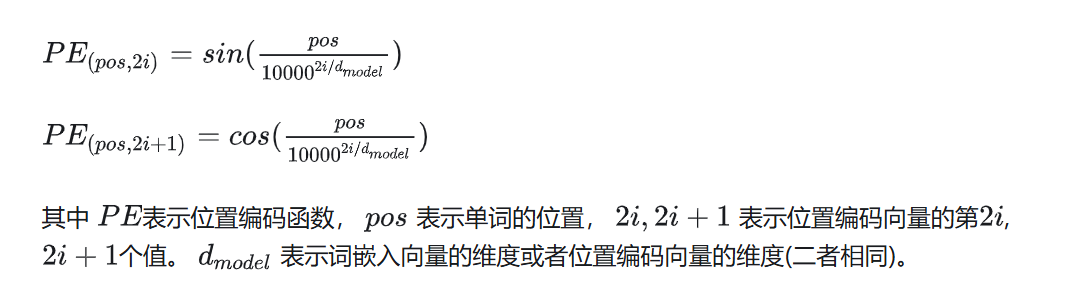

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """最长文本长度： max_len """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # (d_model/2)
        
        pe[:, 0::2] = torch.sin(position * div_term)  # (max_len, 1) * (d_model/2) -- > (max_len, d_model/2)  位置上长度相同或是一个为1 可以对应位置计算
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x : [seq_len, batch_size, embedding_dim=d_model]
        pe[:x.size(0),:]  [seq_len, 1, d_model]
        """
        x = x + self.pe[:x.size(0), :]  # 位置编码 + 字编码  [seq_len, batch_size, d_model]

        return self.dropout(x)  # 部分参数一次更新中不参与更新，防止过拟合

# PositionalEncoding(d_model)

### padding_mask + look_ahead_mask

In [4]:
def get_atten_pad_mask(seq_q, seq_k):
    """
    seq_q : [batch_size, seq_len]  # 自己按照空格分词，有多少词就有多少长度
    seq_k : [batch_size, seq_len]
    seq_len 可以是encoder 输入端的文本长度，也可以是decoder 端的输入文本长度
    seq_q 、 seq_k 可能不同，当计算self_attention 时，二者相同，当计算encoder_decoder_attention 时可能不同
    """
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # PAD  id==0 的地方，防止参与softmax 计算
    pad_attn_mask = seq_k.eq(0).unsqueeze(1)  # [batch_size, 1, len_k]  , True 就是需要被maksed 的
    # [batch_szie, len_q, len_k]
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # 对于一条数据而言，如果是self_attention， 实际上是一个矩阵，每一个词对每一个词的权重上是否需要被mask，因此是[len_q, len_k]

def get_attn_subsquence_mask(seq):
    """
    seq: [batch_size, tgt_len]
    """
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # 对角线以上全为1， 不包含对角线, k 可以理解为第一行后移几位不动，其他赋值为0
    subqequence_mask = torch.from_numpy(subsequence_mask).byte()  # 获取上三角0-1矩阵，对角线上面为1

    return subsequence_mask  # [batch_size, tgt_len, tgt_len]

### 多头自注意力 + 前向全连接


In [5]:
# 专门根据Q, K, V, attn_mask 计算softmax
class ScaledDotPriductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotPriductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        """
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        """
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)  # scores [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9)  # 将mask中为True的元素对应的基础Tensor的元素设置为值value
        # 填充为负无穷之后 e的负无穷接近为0，不影响权重分配
        attn = nn.Softmax(dim = -1)(scores)  # [batch_size, n_heads, len_q, len_k]
        context = torch.matmul(attn, V)  #[batch_size, n_heads, len_q, d_v]
        # print('Scaled：', context.shape, attn.shape)
        return context, attn

# 多头自注意力实现
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        # 输入的是编码后的enc_outputs [batch_size, src_len, d_model]  对于每一个seq_len 上的token(字) 作为一条进行形状变换
        # 因为有多个头，因此d_k * n_heads
        self.W_Q = nn.Linear(d_model, d_k*n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k*n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v*n_heads, bias=False)
        self.fc = nn.Linear(n_heads*d_v, d_model, bias=False)  # 多头结果拼接在一起，与传入的维度发生变化，需要进行一次形状变换，后传入给ffd层
    
    def forward(self, input_Q, input_K, input_V, attn_mask):
        """
        # 为了计算Q矩阵，而放进来的输入矩阵名为input_Q ，encoder端就是经过编码后的矩阵
        # 因为不知道放入的是src 还是 tgt 还是二者都有，因此下面使用len_q 而不是代替src_len 和 tgt_len
        input_Q:  [batch_szie, len_q, d_model]
        input_K:  [batch_size, len_k, d_Model]
        input_V:  [batch_size, len_v(=len_k), d_model]  # len_k 与len_v 一定相同，二者来自同一条数据的同一侧，但与len_q不一定相同，计算encoder_decoder_attn是分别来自encoder 和 decoder
        attn_mask: [batch_szie, seq_len, seq_len]
        """
        residual, batch_size = input_Q, input_Q.size(0)  # residual 残差网络需要传入变化前的原始向量
        # (batch_szie, seq_len, d_model) -- > (batch_szie, seq_len, d_model_new) -split--> (batch_size, seq_len, n_heads, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # Q: [batch_szie, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1, 2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)  # [batch_size, n_heads, seq_len, seq_len]
        # context : [batch_size, n_heads, len_q, d_v]
        # attn:  [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotPriductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads*d_v)  # [batch_size, len_q, n_heads*d_v]  # 多头处理，以及d_v可能不等于d_k ，需要进行形状变换，变为原始的形状
        output = self.fc(context)  # [batch_size, len_q, d_model]
        # print('MultiHead：', context.shape, attn.shape)
        return nn.LayerNorm(d_model)(output + residual), attn
    
# 双层前向全连接，提取特征，做非线性变化
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )

    def forward(self, inputs):
        """
        inputs: [batch_size, seq_len, d_model]  传入的就是多头自注意力之后的  
        """
        residual = inputs
        outputs = self.fc(inputs)
        return nn.LayerNorm(d_model)(outputs + residual)  # [batch_size, seq_len, d_model]

### 编码部分

- EncoderLayer
- Encoder

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()
    
    def forward(self, enc_inputs, enc_self_attn_mask):
        """
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        """
        # enc_outputs:  [batch_size, src_len, d_model]
        # enc_self_attn_mask:  [batch_size, n_heads, len_q=src_len, len_k=src_len]
        # 经过多头自注意力
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)  # enc_inputs to same Q,K,V
        # 经过前向全连接 [batch_size, src_len, d_model]
        enc_outputs = self.pos_ffn(enc_outputs) 
        return enc_outputs, attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)  # [batch_size, enc_seq_len, embedding_dim]
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])  # 多个block

    def forward(self, enc_inputs):
        """
        enc_inputs: [batch_size, seq_len]
        """
        enc_embeded = self.src_emb(enc_inputs)  #[batch_size, src_len, d_model]
        # 输出经过位置编码处理(返回的是位置编码+输入的字编码)
        enc_outputs = self.pos_emb(enc_embeded.transpose(0,1)).transpose(0,1)  # [batch_size, src_len, d_model]
        enc_self_attn_mask = get_atten_pad_mask(enc_inputs, enc_inputs)  # [batch_size, src_len, src_len]
        enc_self_attns = []  # 可以用于划分热力图使用，也可以直接删除
        # 编码之后的数据，传入到layer中
        for layer in self.layers:
            # encoder_outputs: [batch_size, src_len, d_model] 
            # enc_self_attn:  [batch_size, src_len, src_len] -->
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        # 返回最后一个block 的enc_outputs 以便后续与decoder 计算使用
        return enc_outputs, enc_self_attns


### 解码部分

- DecoderLayer
- Decoder

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        """
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]  
        dec_enc_attn_mask:  [batch_size, src_len, tgt_len]  
        """
        # ①经过自身的self_attention
        # dec_outputs  [batch_size, len_q=tgt_len, d_model]
        # dec_self_attn  [batch_size, n_heads, len_q=tgt_len, len_k=tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        
        # ②经过dec_enc_attention
        # dec_outputs  [batch_size, tgt_len, d_model]
        # dec_enc_attn  [batch_size, n_heads, tgt_len, src_len]
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)

        # ③经过前向全连接
        dec_outputs = self.pos_ffn(dec_outputs)  # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        """
        dec_inputs:  [batch_size, tgt_len]
        enc_inputs:  [batch_size, src_len]  计算dec_enc_attn_mask 需要
        enc_outputs:  [batch_size, src_len, d_model]
        # 解码器的self_attention中的mask 需要综合 自身的look_ahead mask 和 padding mask两部分
        """
        dec_embed = self.tgt_embed(dec_inputs)                                   # [batch_size, tgt_len, d_model]
        dec_pos_embed = self.pos_emb(dec_embed.transpose(0, 1)).transpose(0, 1)  # [batch_size, tgt_len, d_model]  输入经过位置+字编码
        dec_outputs = dec_pos_embed
        # 获取self_atten_mask
        dec_self_attn_pad_mask = get_atten_pad_mask(dec_inputs, dec_inputs)      # [batch_size, tgt_len, tgt_len]  需要被掩码的PAD 部分， 值为 True ，反之为False
        dec_self_attn_subsequence_mask = get_attn_subsquence_mask(dec_inputs)    # [batch_size, tgt_len, tgt_len]  需要被掩码的上三角之上部分， 值为1, 反之为0
        # 加和之后> 0 部分均为需要掩码部分，上述两部分构成了解码器的self attention mask
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0)  #[batch_size, tgt_len, tgt_len]

        # 获取enc_dec_mask  [batch_size, tgt_len, src_len]
        dec_enc_attn_mask = get_atten_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []  # 可要可不要
        for layer in self.layers:
            # dec_outputs    [batch_size, tgt_len, d_model]
            # dec_self_attn  [batch_size, n_heads, tgt_len, tgt_len]
            # dec_enc_attn   [batch_size, n_heads, tgt_len, src_len] 
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns


In [8]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        # 经过全连接层，按照tgt_vocab_size 进行分类
        self.prohection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        # enc_outputs   [batch_size, src_len, d_model]
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        # dec_outputs   [batch_size, tgt_len, d_model]
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.prohection(dec_outputs)  # [batch_size, tgt_len, tgt_vocab_size]
        print(dec_logits.shape)
        return dec_logits.view(-1, dec_logits.size(-1))  # 转为二维，以便计算损失

model = Transformer()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

d:\application\Anaconda\envs\llama\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# 模型训练

for epoch in range(1000):
    for enc_inputs, dec_inputs, dec_outputs in loader:
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        dec_outputs: [batch_size, tgt_len]
        '''
        optimizer.zero_grad()
        outputs = model(enc_inputs, dec_inputs)  #[batch_size*tgt_len, tgt_vocab_size]
        loss = criterion(outputs, dec_outputs.view(-1))
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
        loss.backward()
        optimizer.step()        

torch.Size([2, 6, 9])
Epoch: 0001 loss = 2.408151
torch.Size([2, 6, 9])
Epoch: 0002 loss = 2.262839
torch.Size([2, 6, 9])
Epoch: 0003 loss = 1.979471
torch.Size([2, 6, 9])
Epoch: 0004 loss = 1.694387
torch.Size([2, 6, 9])
Epoch: 0005 loss = 1.511667
torch.Size([2, 6, 9])
Epoch: 0006 loss = 1.358717
torch.Size([2, 6, 9])
Epoch: 0007 loss = 1.175392
torch.Size([2, 6, 9])
Epoch: 0008 loss = 1.042306
torch.Size([2, 6, 9])
Epoch: 0009 loss = 0.875029
torch.Size([2, 6, 9])
Epoch: 0010 loss = 0.707114
torch.Size([2, 6, 9])
Epoch: 0011 loss = 0.580187
torch.Size([2, 6, 9])
Epoch: 0012 loss = 0.407649
torch.Size([2, 6, 9])
Epoch: 0013 loss = 0.306020
torch.Size([2, 6, 9])
Epoch: 0014 loss = 0.220298
torch.Size([2, 6, 9])
Epoch: 0015 loss = 0.137668
torch.Size([2, 6, 9])
Epoch: 0016 loss = 0.135771
torch.Size([2, 6, 9])
Epoch: 0017 loss = 0.116124
torch.Size([2, 6, 9])
Epoch: 0018 loss = 0.115722
torch.Size([2, 6, 9])
Epoch: 0019 loss = 0.126369
torch.Size([2, 6, 9])
Epoch: 0020 loss = 0.104117


In [12]:
# 预测函数 直接采用贪婪策略
# 根据enc_input 得到 dec_input 得到dec_output
def greedy_decoder(model, enc_input, start_symbol):
    print(enc_input.shape)
    enc_outputs, enc_self_attns = model.encoder(enc_input)
    dec_input = torch.zeros(1, 0).type_as(enc_input.data)
    terminal = False
    next_symbol = torch.tensor(start_symbol)
    dec_str = []

    while not terminal:
        dec_input = torch.cat([dec_input.detach(), torch.tensor([[next_symbol]], dtype=enc_input.dtype)], -1)
        print('decode_input::', dec_input.shape, dec_input)

        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        print('dec_outputs:::', dec_outputs.shape)
        projected = model.prohection(dec_outputs)
        print('projected:::', projected.shape)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]  # torch.max 返回值第一个元素为最大值，第二个元素为最大值位置
        print('prob:::', prob)
        print('======================================')
        next_word = prob.data[-1]  # 这玩意对应的就是decoder_output
        next_symbol = next_word
        dec_str.append(idx2word[next_word.item()])
        if next_symbol == tgt_vocab['E']:
            terminal = True
    return dec_input, dec_str

# Test
print(idx2word)
enc_inputs, _, _ = next(iter(loader))  # 预测时，dec_input 不传入，之传入起点SOS， dec_input 实际上不知道，否则没有预测意义
# 遍历每一条数据
for i in range(len(enc_inputs)):
    greedy_dec_input, dec_str = greedy_decoder(model, enc_inputs[i].view(1, -1), start_symbol=tgt_vocab['S'])
    print(dec_str)
    break

{0: 'P', 1: 'i', 2: 'want', 3: 'a', 4: 'beer', 5: 'coke', 6: 'S', 7: 'E', 8: '.'}
torch.Size([1, 5])
decode_input:: torch.Size([1, 1]) tensor([[6]])
dec_outputs::: torch.Size([1, 1, 512])
projected::: torch.Size([1, 1, 9])
prob::: tensor([1])
decode_input:: torch.Size([1, 2]) tensor([[6, 1]])
dec_outputs::: torch.Size([1, 2, 512])
projected::: torch.Size([1, 2, 9])
prob::: tensor([1, 2])
decode_input:: torch.Size([1, 3]) tensor([[6, 1, 2]])
dec_outputs::: torch.Size([1, 3, 512])
projected::: torch.Size([1, 3, 9])
prob::: tensor([1, 2, 3])
decode_input:: torch.Size([1, 4]) tensor([[6, 1, 2, 3]])
dec_outputs::: torch.Size([1, 4, 512])
projected::: torch.Size([1, 4, 9])
prob::: tensor([1, 2, 3, 5])
decode_input:: torch.Size([1, 5]) tensor([[6, 1, 2, 3, 5]])
dec_outputs::: torch.Size([1, 5, 512])
projected::: torch.Size([1, 5, 9])
prob::: tensor([1, 2, 3, 5, 8])
decode_input:: torch.Size([1, 6]) tensor([[6, 1, 2, 3, 5, 8]])
dec_outputs::: torch.Size([1, 6, 512])
projected::: torch.Size([1,